In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import numpy as np
import tqdm

%matplotlib inline

In [2]:
import matplotlib as mpl

In [3]:
import vehicleDetection

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load the data.

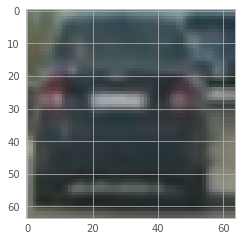

In [4]:
img = mpimage.imread('data/vehicles/vehicles/GTI_MiddleClose/image0000.png')
plt.imshow(img)

In [5]:
images, classes = vehicleDetection.data.getData()

HBox(children=(IntProgress(value=0, max=6726), HTML(value='')))

Images fit comfortably in memory, however.

In [6]:
d = images[0].dtype
print('%.3g MB' % (sum([x.size for x in images]) * d.alignment / 1024. / 1024.,))

315 MB


# Visualize a colorspace.

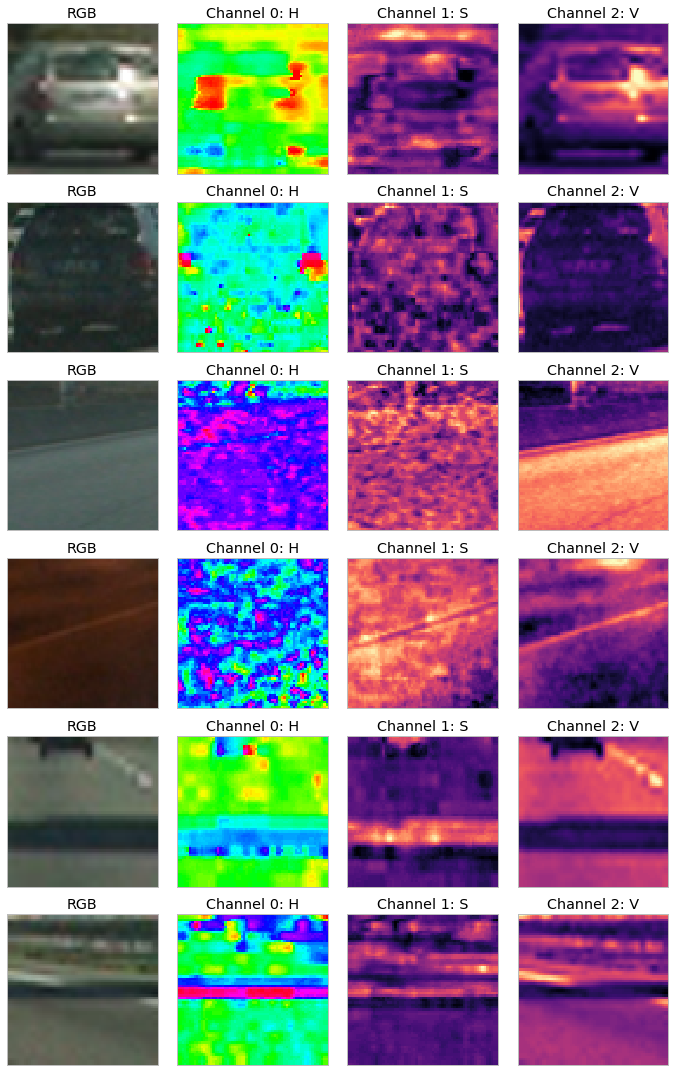

In [7]:
import cv2
def showCspace(img, cspace, axes=None):
    if axes is None:
        fig, axes = plt.subplots(ncols=4, figsize=(20, 6))
    if cspace != 'RGB':
        cvt = cv2.cvtColor(img, getattr(cv2, 'COLOR_RGB2%s' % cspace))
    else:
        cvt = img
    for i, ax in enumerate(axes):
        if i == 0:
            ax.imshow(img)
            ax.set_title('RGB')
        else:
            if len(cspace) == 3:
                c = cspace[i-1]
            else:
                assert cspace == 'YCrCb'
                c = ['Y', 'Cr', 'Cb'][i-1]
                
            if c == 'H':
                cmap = 'hsv'
            else:
                cmap = 'magma'
            ax.imshow(cvt[:, :, i-1], cmap=cmap)
            
            ax.set_title('Channel %d: %s' % (i-1, c))
        ax.set_xticks([])
        ax.set_yticks([])
    return axes

npix = 6
fig, axes = plt.subplots(ncols=4, nrows=npix, figsize=(10, 10. / 4 * npix))
for i in range(npix):
    iimg = [0, 1000, 4000, 5000, 5500, 5600][i]
    showCspace(images[iimg], 'HSV', axes=axes[i]);
fig.tight_layout()

# Fit a detector.

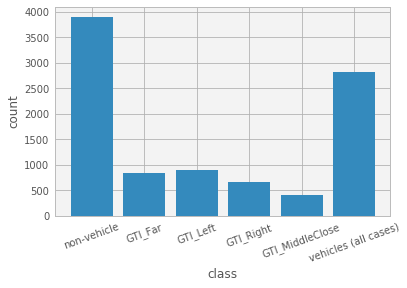

In [8]:
fig, ax = plt.subplots()
classLabels = [0, 1, 2, 3, 4]
x = []
y = []
x.extend(classLabels)
y.extend([classes.count(label) for label in classLabels])
x.append(5)
y.append(np.array(classes).astype(bool).astype(int).sum())
ax.bar(x, y)
ax.set_xticks(range(6))
classLabelNames = ['non-vehicle']
classLabelNames.extend(vehicleDetection.data.subKeys['vehicles'])
classLabelNames.append('vehicles (all cases)')
ax.set_xticklabels(classLabelNames, rotation=20);
ax.set_ylabel('count')
ax.set_xlabel('class');

In [9]:
indices = np.arange(len(images))
np.random.shuffle(indices)
n = 1024
imageWindows = [images[i] for i in indices[:n]]
windowClasses = [classes[i] for i in indices[:n]]

In [172]:
best_params_ = {'gamma': 6.5793322465756827e-05, 'kernel': 'rbf', 'C': 15.199110829529332}
# best_params_ = {'gamma': 10**(-4), 'kernel': 'rbf', 'C': 2}
# best_params_ = {'kernel': 'linear', 'C': 1.0}

Show the hyperparameter search score results.

In [109]:
%%time

if True:
    
    # Do a hyperparameter search.
    detector = vehicleDetection.detector.Detector(
        clfParameters=dict(
            C=np.logspace(-3, 1.6, 12),
            gamma=np.logspace(-8, -2, 12),
        )
    )
    detector.fit(
        imageWindows, 
        windowClasses,
    )
    
    
    # Extract the best parameters.
    best_params_ = detector.clf.best_params_

    
    # Plot the scores from the hyperparameter search.
    scores = [sc.mean_validation_score for sc in detector.clf.grid_scores_]
    Cs = [sc.parameters['C'] for sc in detector.clf.grid_scores_]
    gammas = [sc.parameters['gamma'] for sc in detector.clf.grid_scores_]
    Cflat = list(sorted(set(Cs)))
    gammaflat = list(sorted(set(gammas)))
    grid = np.ones((len(Cflat), len(gammaflat))) * np.mean(scores)
    
    for score, C, gamma in zip(scores, Cs, gammas):
        iC = Cflat.index(C)
        ig = gammaflat.index(gamma)
        grid[iC, ig] = score

    fig, ax = plt.subplots(figsize=(16,9))
    im = ax.imshow(grid, origin='lower', interpolation='spline16', cmap='hot')
    fig.colorbar(im, label='score')

    # sc = ax.scatter(np.log10(gammas), np.log10(Cs), c=scores)
    # fig.colorbar(sc, label='score')

    C = detector.clf.best_params_['C']
    gamma = detector.clf.best_params_['gamma']
    ax.scatter(gammaflat.index(gamma), Cflat.index(C), label='best', color='grey', s=256)

    ax.set_xticks(range(len(gammaflat)))
    ax.set_yticks(range(len(Cflat)))
    logformat = lambda n: '$10^{%.2g}$' % np.log10(n)
    lfm = lambda l: [logformat(n) for n in l]
    ax.set_xticklabels(lfm(gammaflat))
    ax.set_yticklabels(lfm(Cflat))
    ax.set_title('hyperparameter search')
    ax.set_xlabel('$\gamma$')
    ax.set_ylabel('$C$');
    ax.legend();
    fig.savefig('doc/hyperparameterSearch.png')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


# Retrain the classifier on the full dataset with the best classifier parameters.

In [174]:
detector = vehicleDetection.detector.Detector(clfParameters=best_params_)

Got scalar parameter (gamma). Assuming no CV requested.


In [175]:
# Try a decision tree.

# import sklearn.tree
# CLF = sklearn.tree.DecisionTreeClassifier
# best_params_ = dict(min_samples_split=2, min_samples_leaf=1, criterion='gini')
# detector = vehicleDetection.detector.Detector(clfParameters=best_params_, CLF=CLF)

In [176]:
%%time
detector.fit(
    images,
    classes,
)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Test Accuracy of clf =  0.9911
CPU times: user 1min 42s, sys: 4.23 s, total: 1min 46s
Wall time: 1min 56s


### Show the raw and standardized features.

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


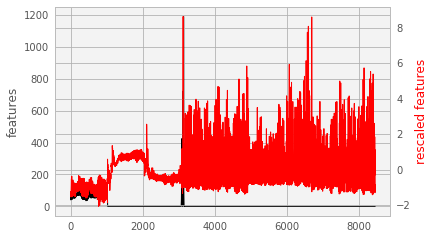

In [113]:
feat = detector.featurize(imageWindows[0]).reshape((1, -1))
rescaled = detector.scaler.transform(feat)
fig, ax = plt.subplots()
ax.plot(feat.ravel(), linewidth=1, color='black')
ax.set_ylabel('features')
# ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(rescaled.ravel(), linewidth=1, color='red');
ax2.set_ylabel('rescaled features', color='red')

# Demonstrate the detector; check accuracy.

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


The classifier rates its accuracy as 0.987362473982


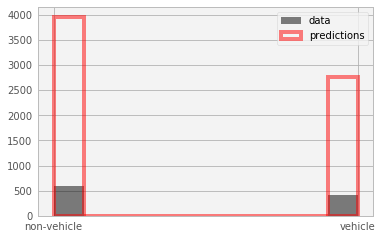

In [114]:
def predict(image):
    feat = detector.featurize(image).reshape((1, -1))
    rescaled = detector.scaler.transform(feat)
    return np.copy(detector.clf.predict(rescaled))

predictions = np.stack([
    predict(np.copy(image)) 
    for image in 
    tqdm.tqdm_notebook(images, desc='predict')
])

fig, ax = plt.subplots()
ax.hist([bool(y) for y in classes], color='black', label='data', alpha=.5);
ax.hist(predictions, edgecolor='red', linewidth=4, label='predictions', alpha=.5, facecolor='none')
ax.legend()
ax.set_xticks([0, 1])
ax.set_xticklabels(['non-vehicle', 'vehicle'])

print(
    'The classifier rates its accuracy as',
    detector.clf.score(
        np.vstack([
            detector.scaler.transform(detector.featurize(image).reshape((1, -1)))
            for image in 
            tqdm.tqdm_notebook(images, desc='feat. & transf.')
        ]),
        [bool(y) for y in classes]
    )
)

# Run the detector on a test image.

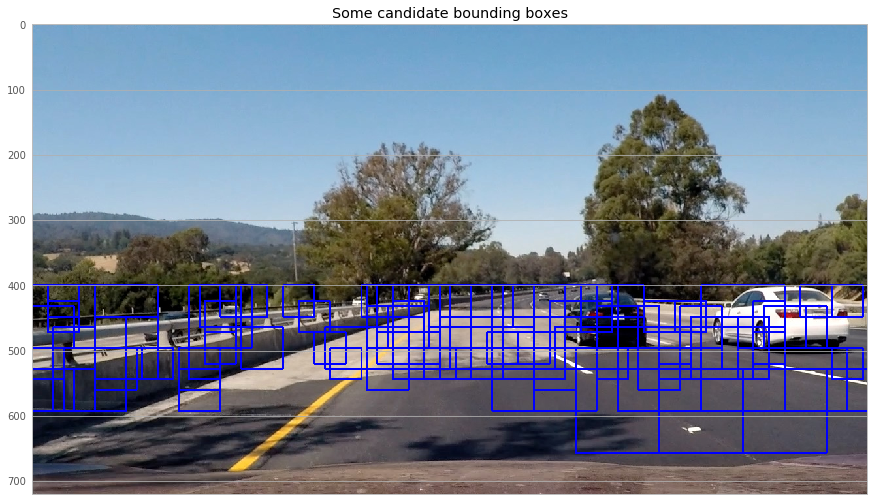

In [177]:
impath = 'test_images/test4.jpg'
img = mpimage.imread(impath)
windows = vehicleDetection.search.slide_window(img)

windows = [w for w in detector.generateWindows(img)]
np.random.shuffle(windows)

nwin = 96
windows[:nwin]

fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(
    vehicleDetection.drawing.draw_boxes(
        img, windows[:nwin], thick=2,
    )
)
ax.set_xticks([]);
# ax.set_yticks([]);
ax.set_title('Some candidate bounding boxes')

Examine the test windows used.

In [178]:
testWindowImages = [
    cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
    for window in windows
]


What is the distribution of predictions on this test image?

In [179]:
predictions = np.stack([
    detector.clf.predict(
        detector.scaler.transform(
            detector.featurize(im).reshape((1, -1))
        )
    )
    for im in testWindowImages
])

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


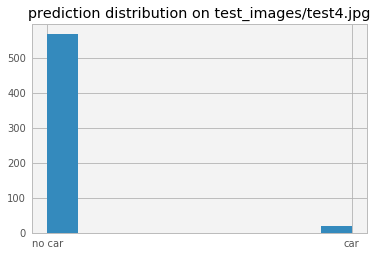

In [180]:
fig, ax = plt.subplots()
ax.hist(predictions)
ax.set_xticks([0, 1])
ax.set_xticklabels(['no car', 'car'])
ax.set_title('prediction distribution on %s' % impath);

Compare them to the training data.

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


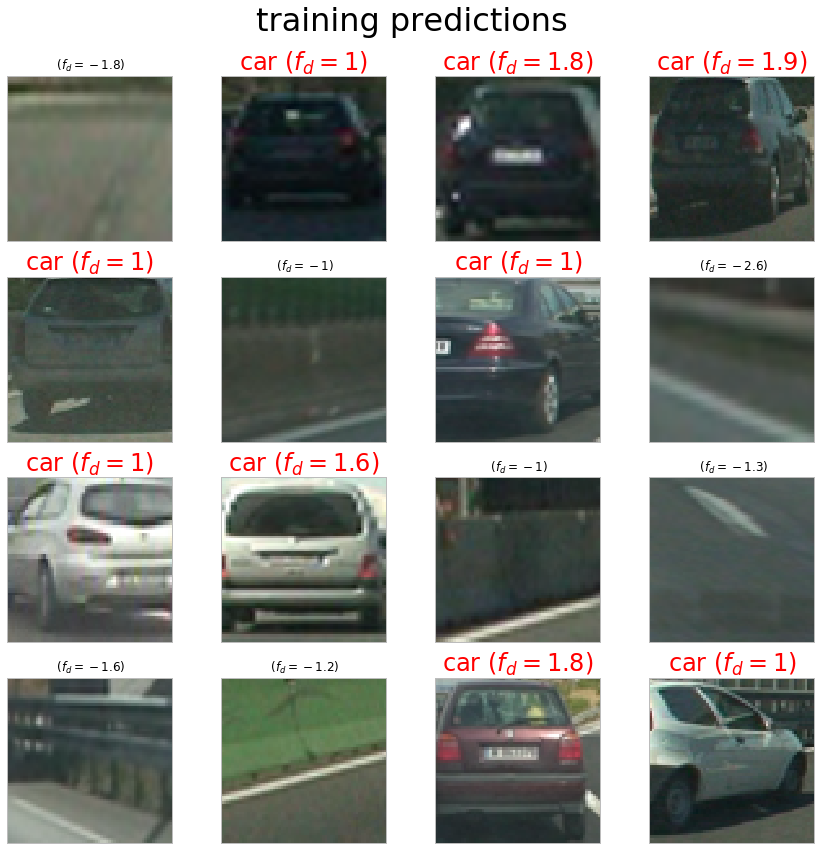

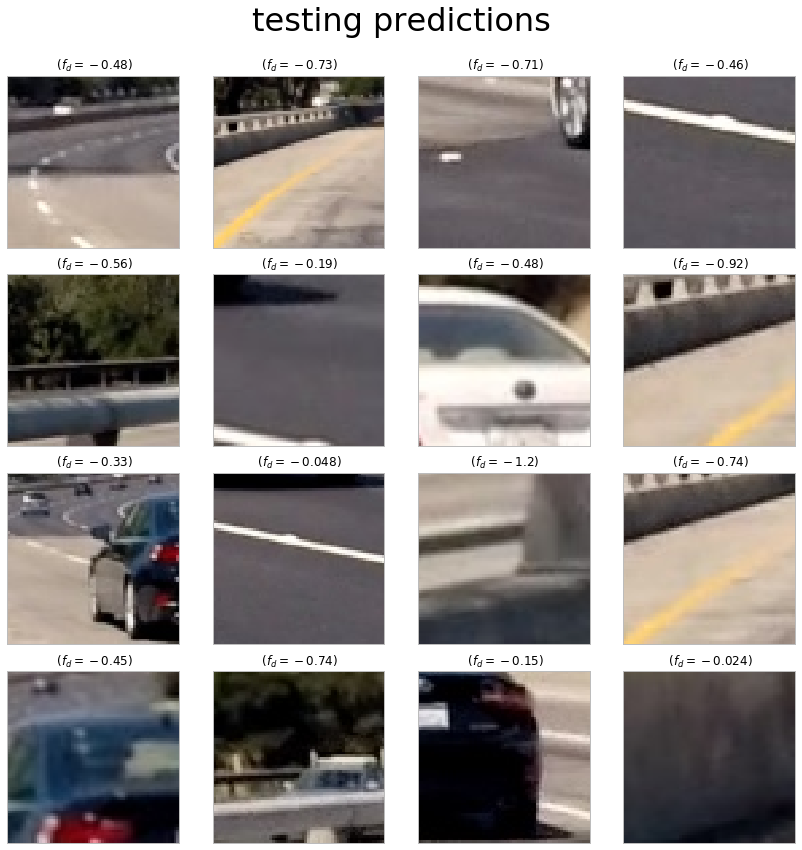

In [181]:
for imgs, suptitle in zip([imageWindows, testWindowImages], ['training predictions', 'testing predictions']):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    axes = axes.ravel()
    for im, ax in zip(imgs, axes):
        if (np.abs(im) <= 1).all():
            ax.imshow(np.clip(im*255, 0, 255).astype('uint8'))
#             ax.imshow(im)
        else:
            ax.imshow(im)
        features = detector.featurize(im).reshape((1, -1))
        test_features = detector.scaler.transform(features)
        pred = detector.clf.predict(test_features)
        if hasattr(detector.clf, 'decision_function'):
            decisionFunc = detector.clf.decision_function(test_features)
            dftext = ' ($f_d=%.2g$)' % decisionFunc
        else:
            dftext = ''
        ax.set_xticks([]); ax.set_yticks([])
        title = 'car%s' % dftext if pred else dftext
        ax.set_title(
            title, 
            color='red' if pred else 'black',
            fontsize=24 if pred else 12
        )
    fig.tight_layout()
    fig.suptitle(suptitle, fontsize=32)
    fig.subplots_adjust(top=.9)
    fig.savefig('doc/%s.png' % suptitle)

In [182]:
windows = detector.rawDetect(img)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [183]:
len(windows), len(detector.generateWindows(img))

(19, 587)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


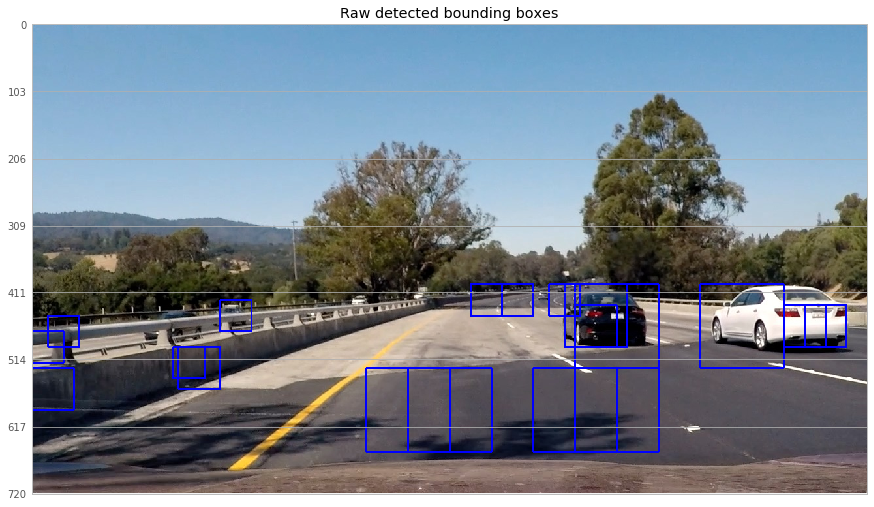

In [184]:
# from IPython.core.debugger import set_trace; set_trace()
ax = detector.drawDetect(img)
ax.set_title('Raw detected bounding boxes')
ax.set_yticks(np.round(np.linspace(0, 720, 8)));

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


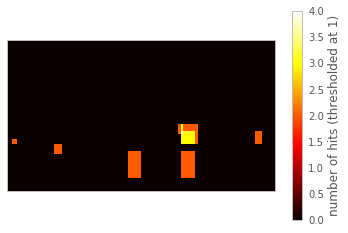

In [185]:
heatmap = detector.heat(img.shape, detector.rawDetect(img))
thr = 1
heatmap[heatmap <= thr] = 0
fig, ax = plt.subplots()
im = ax.imshow(heatmap[:, :, 0], cmap=mpl.cm.hot)
fig.colorbar(im, label='number of hits (thresholded at %d)' % thr)
ax.set_xticks([])
ax.set_yticks([]);

In [186]:
set(heatmap.ravel())

{0.0, 2.0, 3.0, 4.0}

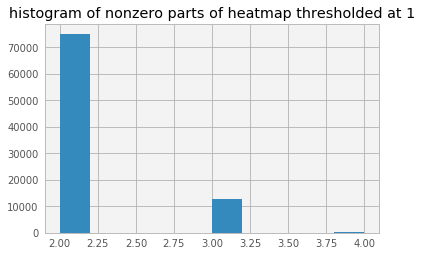

In [187]:
fig, ax = plt.subplots()
nz = heatmap[heatmap>0]
ax.hist(nz.ravel());
ax.set_title('histogram of nonzero parts of heatmap thresholded at %d' % thr);

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Found 6 labels.


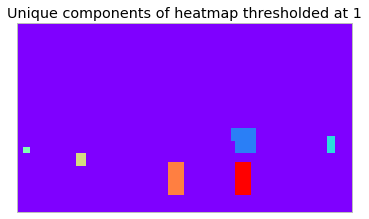

In [188]:
labels = detector.detect(img, threshold=thr)[0][:, :, 0]
fig, ax = plt.subplots()
ax.imshow(labels, cmap=mpl.cm.rainbow)
ax.set_xticks([])
ax.set_yticks([]);
ax.set_title('Unique components of heatmap thresholded at %d' % thr)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Found 6 labels.


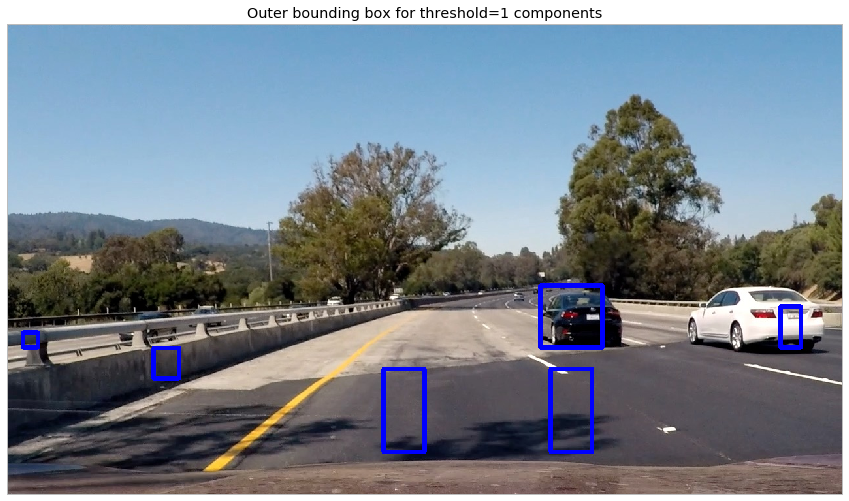

In [189]:
# from IPython.core.debugger import set_trace; set_trace()
ax = detector.drawHeat(img, threshold=thr)
ax.set_title('Outer bounding box for threshold=%d components' % thr)